In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
tf.config.experimental.list_physical_devices('GPU')
import datetime

<h2>Extract MNIST data</h2>
<p style="font-size:20px">You can change the option of one_hot encoding.

In [2]:
#get mnist data, with one_hot encoding
mnist = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(train_images, train_labels), (test_images, test_labels) = mnist
tl = train_labels
train_images = train_images.astype("float32")/255.0
test_images = test_images.astype("float32")/255.0
train_labels = tf.one_hot(train_labels,depth=10)
test_labels = tf.one_hot(test_labels, depth=10)

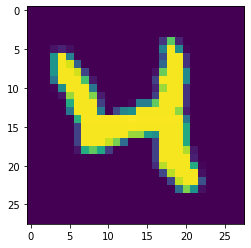

In [5]:
plt.figure()
plt.imshow(train_images[20])
plt.grid(False)
plt.show()

<h2>Define placeholder and Variables</h2>

In [6]:
def mnist_model(hp):
    """
    define model for hyper tune
    """
    activation = hp.Choice("activation", values=['relu', 'tanh', 'sigmoid'])

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=16, max_value=256, step=16),
                activation=activation,
            )
        )
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1.0, 1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model

<h2>Define tuner</h2>

In [7]:
tuner = kt.Hyperband(
    mnist_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='minst_tuner_1'
)



stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

tuner.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 1.0, 'conditions': [], 'values': [1.0, 0.01, 0.001, 0.0001], 'ordered': True}


In [8]:
#START TUNING
tuner.search(train_images, train_labels, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 01m 00s]
val_accuracy: 0.1080833300948143

Best val_accuracy So Far: 0.9735000133514404
Total elapsed time: 00h 15m 03s
INFO:tensorflow:Oracle triggered exit


<h2>Execute training</h2>

In [9]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="/my_dir/mnist_logs")
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images,
                    train_labels,
                    batch_size=64,
                    epochs=20,
                    validation_data=(test_images, test_labels),
                    callbacks=[tb_callback])

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2577 - accuracy: 0.9228 - val_loss: 0.1458 - val_accuracy: 0.9554
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1196 - accuracy: 0.9644 - val_loss: 0.1304 - val_accuracy: 0.9605
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0855 - accuracy: 0.9736 - val_loss: 0.0984 - val_accuracy: 0.9693
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0646 - accuracy: 0.9794 - val_loss: 0.0915 - val_accuracy: 0.9729
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0492 - accuracy: 0.9840 - val_loss: 0.0922 - val_accuracy: 0.9707
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0420 - accuracy: 0.9864 - val_loss: 0.0783 - val_accuracy: 0.9765
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.0886 - val_accuracy: 0.9751
Epoch 

<h2>Your results</h2>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epoch')

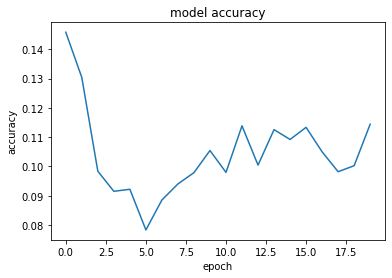

In [10]:
print(history.history.keys())
plt.plot(history.history["val_loss"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [11]:
acc=model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1144 - accuracy: 0.9754


In [12]:
tuner.oracle.get_best_trials()[0].trial_id
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 240)               188400    
_________________________________________________________________
dense_7 (Dense)              (None, 176)               42416     
_________________________________________________________________
dense_8 (Dense)              (None, 80)                14160     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               10368     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 256,634
Trainable params: 256,634
Non-trainable params: 0
________________________________________________

In [13]:
tuner.results_summary()

Results summary
Results in my_dir\minst_tuner_1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: tanh
num_layers: 4
units_0: 240
units_1: 176
learning_rate: 0.001
units_2: 80
units_3: 128
units_4: 208
units_5: 32
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9735000133514404
Trial summary
Hyperparameters:
activation: relu
num_layers: 3
units_0: 32
units_1: 96
learning_rate: 0.001
units_2: 224
units_3: 48
units_4: 64
units_5: 144
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9700000286102295
Trial summary
Hyperparameters:
activation: tanh
num_layers: 5
units_0: 80
units_1: 240
learning_rate: 0.001
units_2: 128
units_3: 144
units_4: 192
units_5: 240
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 3a086c4deb4bfb7343b5df40ace08fec
Score: 0.9679166674613953
Trial summary
Hyperparameters:
activation: tanh
num_layers: 3


In [ ]:
tf.keras